In [2]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=$HOME
!make
!make install

!TA_LIBRARY_PATH=~/lib TA_INCLUDE_PATH=~/include pip install ta-lib

--2023-05-31 10:24:17--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-05-31 10:24:18--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://kumisystems.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-05-31 10:24:18--  http://kumisystems.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving kumisys

In [3]:
pip install yfinance imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 56.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
# from tvDatafeed import tvDatafeed, Interval
# tv = TvDatafeed()
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import talib

In [7]:
# data = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2]
# symbols = list(data.Symbol)
# tickers = list(data.Symbol + '.NS')

# vix_df = pd.read_csv('/data/notebook_files/indices_historical_data (1).csv')
# vix_df['Date'] = pd.to_datetime(vix_df['Date'])
# vix_df.index = vix_df['Date']
# vix_df = vix_df.rename(columns = {'Close':'Vix_Close'})
# vix_df = vix_df['Vix_Close']

In [91]:
data = pd.read_csv('/data/notebook_files/ind_nifty500list.csv')
symbols = list(data.Symbol)
tickers = list(data.Symbol + '.NS')

vix_df = pd.read_csv('/data/notebook_files/indices_historical_data (1).csv')
vix_df['Date'] = pd.to_datetime(vix_df['Date'])
vix_df.index = vix_df['Date']
vix_df = vix_df.rename(columns = {'Close':'Vix_Close'})
vix_df = vix_df['Vix_Close']

In [14]:
df = yf.download(tickers[1], start = '2008-01-01', end='2023-05-01')

df1 = df.copy()


days=156                                        #Training Dataset
c=1                                             #Model Look back period 
n=25                                            #Moving Average and Z-period  

df1 = df1[['Open','Close']]
df1 = df1.resample('W').last()


df1['Daily_ret'] = np.log(df1['Close']/df1['Close'].shift(1))

for a in range(1,6,1):
    df1['Daily_ret_lag{}'.format(a)] = df1['Daily_ret'].shift(a)     

df1['Moving_average'] = df1.Close.rolling(int(n)).mean()
df1['STD'] = df1.Close.rolling(int(n)).std()
df1['STD/Close'] = df1['STD']/df1['Close']

df1['z_score'] = (df1['Close'] - df1['Moving_average'])/df1['STD']

for b in range(1,6,1):
    df1['z_score_lag{}'.format(b)] = df1['z_score'].shift(b) 

df1['z_scoremax{}_days'.format(n)] = df1.z_score.rolling(int(n)).max()
df1['z_scoremin{}_days'.format(n)] = df1.z_score.rolling(int(n)).min()
df1['position'] = np.where((df1['z_score']<df1['z_scoremin{}_days'.format(n)].shift()) & (df1['z_score'].shift()>df1['z_scoremin{}_days'.format(n)].shift()), 1, 0)

df1['overnight_ret'] = np.log(df1['Open']/df1['Close'].shift(1))
for u in range(1,6,1):
    df1['overnight_ret_lag{}'.format(u)] = df1['overnight_ret'].shift(u)

df1['RSI']  = talib.RSI(df1['Close'], 14)
for d in range(1,6,1):
    df1['RSI_lag{}'.format(d)] = df1['RSI'].shift(d)

df1['MACD_fast'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[0]
for e in range(1,6,1):
    df1['MACD_fast_lag{}'.format(e)] = df1['MACD_fast'].shift(e)

df1['MACD_slow'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[1]
for f in range(1,6,1):
    df1['MACD_slow_lag{}'.format(f)] = df1['MACD_slow'].shift(f)

df1['MACD_signal'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[2]
for g in range(1,6,1):
    df1['MACD_signal_lag{}'.format(g)] = df1['MACD_signal'].shift(g)

vix_df = vix_df.resample('W').last()

df1 = pd.concat([df1, vix_df], axis=1)
for h in range(1,6,1):
    df1['Vix_Close_lag{}'.format(h)] = df1['Vix_Close'].shift(h)   

df1['Vix<20'] = np.where(df1['Vix_Close']<=20, 1, 0)
df1['20<Vix<30'] = np.where((df1['Vix_Close'] > 20) & (df1['Vix_Close'] < 30), 1, 0)
df1['Vix<20>30'] = np.where(df1['Vix_Close']>=30, -1, 0)

df1['direction'] = np.where(df1['Daily_ret']>0, 1, 0)
df1['direction'] = df1['direction'].shift(-1)

df1 = df1.iloc[2*n+5:]
df1 = df1.dropna()

df2 = df1.copy()

X = df1.drop(columns=['direction', 'Open', 'Close', 'Moving_average', 'STD'])
Y = df1['direction']

smote = SMOTE(sampling_strategy = 'minority')
X_sm, Y_sm = smote.fit_resample(X, Y)

predictions = []
probability = []

for i in range(0, len(df2), c):

    X_train, Y_train = X_sm.iloc[i:i+days], Y_sm.iloc[i:i+days]

    Sts = StandardScaler()
    X_train_std = Sts.fit_transform(X_train)

    if X.iloc[i+days:i+days+c].shape[0] == 0:
        continue

    X_std = Sts.transform(X.iloc[i+days:i+days+c].values.reshape(-1, X.shape[1]))

    nn_model = keras.Sequential([
                                keras.layers.Dense(64, input_shape=(55,), activation='relu'),
                                keras.layers.Dense(128, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(64, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(1, activation='sigmoid')
                                ])

    nn_model.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

    history = nn_model.fit(X_train_std, Y_train, batch_size= 8, epochs = 100)

    X_pred_ar = nn_model.predict(X_std)
    X_pred = X_pred_ar.tolist()

    pred_binary = []

    for i in range(X_pred_ar.shape[0]):
        pred_binary.append(round(X_pred[i][0]))

    for i in pred_binary:
        predictions.append(i)

    for i in X_pred:
        probability.append(i[0])

df1 = df1.iloc[days:]
df1['predicted_direction'] = predictions
df1['strategy_ret'] = df1['Daily_ret'] * df1['predicted_direction'].shift(1)
df1['predicted_prob'] = probability


df1 = df1.dropna()

df1

Epoch 65/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0471 - accuracy: 0.9808
Epoch 66/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0619 - accuracy: 0.9744
Epoch 67/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0348 - accuracy: 0.9936
Epoch 68/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0362 - accuracy: 0.9936
Epoch 69/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0307 - accuracy: 0.9936
Epoch 70/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0273 - accuracy: 1.0000
Epoch 71/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0130 - accuracy: 1.0000
Epoch 72/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0264 - accuracy: 0.9936
Epoch 73/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0438 - accuracy: 0.9872
Epoch 74/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0291 - accuracy: 0.9936


KeyboardInterrupt: KeyboardInterrupt: 

In [113]:
df = yf.download(tickers[33], start = '2008-01-01', end='2023-05-01')

df1 = df.copy()

days=156                                        #Training Dataset
c=1                                             #Model Look back period 
n=20                                            #Moving Average and Z-period  

df1 = df1[['Open','Close']]
#df1 = df1.resample('W').last()


df1['Daily_ret'] = np.log(df1['Close']/df1['Close'].shift(1))

for a in range(1,6,1):
    df1['Daily_ret_lag{}'.format(a)] = df1['Daily_ret'].shift(a)     

df1['Moving_average'] = df1.Close.rolling(int(n)).mean()
df1['STD'] = df1.Close.rolling(int(n)).std()
df1['STD/Close'] = df1['STD']/df1['Close']

df1['z_score'] = (df1['Close'] - df1['Moving_average'])/df1['STD']

for b in range(1,6,1):
    df1['z_score_lag{}'.format(b)] = df1['z_score'].shift(b) 

df1['z_scoremax{}_days'.format(n)] = df1.z_score.rolling(int(n)).max()
df1['z_scoremin{}_days'.format(n)] = df1.z_score.rolling(int(n)).min()
df1['position'] = np.where((df1['z_score']<df1['z_scoremin{}_days'.format(n)].shift()) & (df1['z_score'].shift()>df1['z_scoremin{}_days'.format(n)].shift()), 1, 0)

df1['overnight_ret'] = np.log(df1['Open']/df1['Close'].shift(1))
for u in range(1,6,1):
    df1['overnight_ret_lag{}'.format(u)] = df1['overnight_ret'].shift(u)

df1['RSI']  = talib.RSI(df1['Close'], 14)
for d in range(1,6,1):
    df1['RSI_lag{}'.format(d)] = df1['RSI'].shift(d)

df1['MACD_fast'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[0]
for e in range(1,6,1):
    df1['MACD_fast_lag{}'.format(e)] = df1['MACD_fast'].shift(e)

df1['MACD_slow'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[1]
for f in range(1,6,1):
    df1['MACD_slow_lag{}'.format(f)] = df1['MACD_slow'].shift(f)

df1['MACD_signal'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[2]
for g in range(1,6,1):
    df1['MACD_signal_lag{}'.format(g)] = df1['MACD_signal'].shift(g)

#vix_df = vix_df.resample('W').last()

df1 = pd.concat([df1, vix_df], axis=1)
for h in range(1,6,1):
    df1['Vix_Close_lag{}'.format(h)] = df1['Vix_Close'].shift(h)   

df1['Vix<20'] = np.where(df1['Vix_Close']<=20, 1, 0)
df1['20<Vix<30'] = np.where((df1['Vix_Close'] > 20) & (df1['Vix_Close'] < 30), 1, 0)
df1['20<Vix>30'] = np.where(df1['Vix_Close']>=30, 1, 0)

df1['direction'] = np.where(df1['Daily_ret']>0, 1, 0)
df1['direction'] = df1['direction'].shift(-1)

#df1 = df1.iloc[2*n+5:]
df1 = df1.dropna()

df2 = df1.copy()

X = df1.drop(columns=['direction', 'Open', 'Close', 'Moving_average', 'STD'])
Y = df1['direction']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42, stratify=Y)

# smote = SMOTE(sampling_strategy = 'minority')
# X_sm, Y_sm = smote.fit_resample(X_train, Y_train)

Sts = StandardScaler()

X_train_std = Sts.fit_transform(X_train)
X_test_std = Sts.transform(X_test)

nn_model = keras.Sequential([
                            keras.layers.Dense(64, input_shape=(55,), activation='relu'),
                            keras.layers.Dense(128, activation='relu'),
                            keras.layers.Dropout(0.5),
                            keras.layers.Dense(64, activation='relu'),
                            keras.layers.Dropout(0.5),
                            keras.layers.Dense(1, activation='sigmoid')
                            ])

nn_model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

history = nn_model.fit(X_train_std, Y_train, epochs = 100)

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
102/102 [==============================] - 1s 2ms/step - loss: 0.7200 - accuracy: 0.5078
Epoch 2/100
102/102 [==============================] - 0s 2ms/step - loss: 0.7049 - accuracy: 0.5017
Epoch 3/100
102/102 [==============================] - 0s 2ms/step - loss: 0.6956 - accuracy: 0.5161
Epoch 4/100
102/102 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.5274
Epoch 5/100
102/102 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5232
Epoch 6/100
102/102 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5336
Epoch 7/100
102/102 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5213
Epoch 8/100
102/102 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.5400
Epoch 9/100
102/102 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.5412
Epoch 10/100
102/102 [

In [114]:
Y_test.value_counts()

0.0 185
1.0 178
Name: direction, dtype: int64

In [115]:
nn_model.evaluate(X_test_std, Y_test)

12/12 [==============================] - 0s 941us/step - loss: 1.8803 - accuracy: 0.4766


[1.8803375959396362, 0.4765840172767639]

In [12]:
final_list = []

for i in range(len(tickers)):

  df = yf.download(tickers[i], start = '2008-01-01', end='2023-05-01')

  df1 = df.copy()
    

  days=156                                        #Training Dataset
  c=1                                             #Model Look back period 
  n=25                                            #Moving Average and Z-period  

  df1 = df1[['Open','Close']]
  df1 = df1.resample('W').last()


  df1['Daily_ret'] = np.log(df1['Close']/df1['Close'].shift(1))

  for a in range(1,6,1):
      df1['Daily_ret_lag{}'.format(a)] = df1['Daily_ret'].shift(a)     

  df1['Moving_average'] = df1.Close.rolling(int(n)).mean()
  df1['STD'] = df1.Close.rolling(int(n)).std()
  df1['STD/Close'] = df1['STD']/df1['Close']

  df1['z_score'] = (df1['Close'] - df1['Moving_average'])/df1['STD']

  for b in range(1,6,1):
      df1['z_score_lag{}'.format(b)] = df1['z_score'].shift(b) 

  df1['z_scoremax{}_days'.format(n)] = df1.z_score.rolling(int(n)).max()
  df1['z_scoremin{}_days'.format(n)] = df1.z_score.rolling(int(n)).min()
  df1['position'] = np.where((df1['z_score']<df1['z_scoremin{}_days'.format(n)].shift()) & (df1['z_score'].shift()>df1['z_scoremin{}_days'.format(n)].shift()), 1, 0)

  df1['overnight_ret'] = np.log(df1['Open']/df1['Close'].shift(1))
  for u in range(1,6,1):
      df1['overnight_ret_lag{}'.format(u)] = df1['overnight_ret'].shift(u)

  df1['RSI']  = talib.RSI(df1['Close'], 14)
  for d in range(1,6,1):
      df1['RSI_lag{}'.format(d)] = df1['RSI'].shift(d)

  df1['MACD_fast'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[0]
  for e in range(1,6,1):
      df1['MACD_fast_lag{}'.format(e)] = df1['MACD_fast'].shift(e)

  df1['MACD_slow'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[1]
  for f in range(1,6,1):
      df1['MACD_slow_lag{}'.format(f)] = df1['MACD_slow'].shift(f)

  df1['MACD_signal'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[2]
  for g in range(1,6,1):
      df1['MACD_signal_lag{}'.format(g)] = df1['MACD_signal'].shift(g)

  vix_df = vix_df.resample('W').last()

  df1 = pd.concat([df1, vix_df], axis=1)
  for h in range(1,6,1):
      df1['Vix_Close_lag{}'.format(h)] = df1['Vix_Close'].shift(h)   

  df1['Vix<20'] = np.where(df1['Vix_Close']<=20, 1, 0)
  df1['20<Vix<30'] = np.where((df1['Vix_Close'] > 20) & (df1['Vix_Close'] < 30), 1, 0)
  df1['Vix<20>30'] = np.where(df1['Vix_Close']>=30, -1, 0)

  df1['direction'] = np.where(df1['Daily_ret']>0, 1, 0)
  df1['direction'] = df1['direction'].shift(-1)

  df1 = df1.iloc[2*n+5:]
  df1 = df1.dropna()

  df2 = df1.copy()

  X = df1.drop(columns=['direction', 'Open', 'Close', 'Moving_average', 'STD'])
  Y = df1['direction']

  smote = SMOTE(sampling_strategy = 'minority')
  X_sm, Y_sm = smote.fit_resample(X, Y)
  
  predictions = []
  probability = []

  for i in range(0, len(df2), c):

    X_train, Y_train = X_sm.iloc[i:i+days], Y_sm.iloc[i:i+days]

    Sts = StandardScaler()
    X_train_std = Sts.fit_transform(X_train)

    if X.iloc[i+days:i+days+c].shape[0] == 0:
      continue

    X_std = Sts.transform(X.iloc[i+days:i+days+c].values.reshape(-1, X.shape[1]))

    nn_model = keras.Sequential([
                                keras.layers.Dense(64, input_shape=(55,), activation='relu'),
                                keras.layers.Dense(128, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(64, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(1, activation='sigmoid')
                                ])
    
    nn_model.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    
    history = nn_model.fit(X_train_std, Y_train, batch_size= 8, epochs = 100)

    X_pred_ar = nn_model.predict(X_std)
    X_pred = X_pred_ar.tolist()

    pred_binary = []
    for i in range(X_pred_ar.shape[0]):
      pred_binary.append(round(X_pred[i][0]))
    
    for i in pred_binary:
        predictions.append(i)

    for i in X_pred:
      probability.append(i[0])

  df1 = df1.iloc[days:]
  df1['predicted_direction'] = predictions
  df1['strategy_ret'] = df1['Daily_ret'] * df1['predicted_direction'].shift(1)
  df1['predicted_prob'] = probability


  df1 = df1.dropna()

  final_list.append(df1)

Epoch 64/100
20/20 [==============================] - 0s 1ms/step - loss: 0.1028 - accuracy: 0.9679
Epoch 65/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0728 - accuracy: 0.9872
Epoch 66/100
20/20 [==============================] - 0s 1ms/step - loss: 0.1318 - accuracy: 0.9551
Epoch 67/100
20/20 [==============================] - 0s 1ms/step - loss: 0.1530 - accuracy: 0.9359
Epoch 68/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0755 - accuracy: 0.9872
Epoch 69/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9872
Epoch 70/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0676 - accuracy: 0.9936
Epoch 71/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0244 - accuracy: 1.0000
Epoch 72/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0307 - accuracy: 1.0000
Epoch 73/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0292 - accuracy: 1.0000


ValueError: ValueError: Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required by SMOTE.

In [70]:
multi_position = []
overnight = []
final_prob = []

for i in final_list:

  mpdf = i.loc[:,'predicted_direction']
  multi_position.append(mpdf)
  
  ovrn_ret = i.loc[:,'Daily_ret']
  overnight.append(ovrn_ret)

  probab = i.loc[:,'predicted_prob']
  final_prob.append(probab)

multi_position_df = pd.DataFrame(multi_position).T.shift()
multi_position_df.columns = symbols
  
overnight_df = pd.DataFrame(overnight).T
overnight_df.columns = symbols

final_prob_df = pd.DataFrame(final_prob).T.shift()
final_prob_df.columns = symbols

stocks_trade = []

for i in range(len(final_prob_df)):
    sorted_probabilities = final_prob_df.iloc[i]
    sorted_probabilities = sorted_probabilities[sorted_probabilities>0.50]
    sorted_probabilities = sorted_probabilities.sort_values(ascending=False).nlargest(10)
    sorted_columns = sorted_probabilities.index.tolist()
    stocks_trade.append(sorted_columns)

portfolio_returns = []

for i in range(len(stocks_trade)):
    sret = overnight_df.loc[:, stocks_trade[i]] * multi_position_df.loc[:, stocks_trade[i]]
    sret = sret.iloc[i].mean()
    portfolio_returns.append(sret)

strategy_returns = pd.DataFrame(portfolio_returns, columns = ['Returns'])
strategy_returns.index = overnight_df.index
strategy_returns['Strategy_Nav'] = strategy_returns['Returns'].cumsum().apply(np.exp)
strategy_returns['cum_max'] = strategy_returns['Strategy_Nav'].cummax()
strategy_returns['drawdown'] = 100* (strategy_returns['Strategy_Nav'] - strategy_returns['cum_max']) / strategy_returns['cum_max']

strategy_returns['Returns_after_tc'] = strategy_returns['Returns'] + np.log(0.999)
strategy_returns['Strategy_Nav_after_tc'] = strategy_returns['Returns_after_tc'].cumsum().apply(np.exp)
strategy_returns['cum_max_after_tc'] = strategy_returns['Strategy_Nav_after_tc'].cummax()
strategy_returns['drawdown_adter_tc'] = 100* (strategy_returns['Strategy_Nav_after_tc'] - strategy_returns['cum_max_after_tc']) / strategy_returns['cum_max_after_tc']

In [71]:
multi_position_df.iloc[:,4].value_counts()

1.0 479
0.0 458
Name: AXISBANK, dtype: int64

In [72]:
nifty = yf.download('^NSEI', start = '2019-07-18').Close
nifty['Strategy_Nav'] = pd.DataFrame(np.log(nifty/nifty.shift()).cumsum().apply(np.exp))
nifty['cum_max'] = nifty['Strategy_Nav'].cummax()
nifty['drawdown'] = 100* (nifty['Strategy_Nav'] - nifty['cum_max']) / nifty['cum_max']

[*********************100%***********************]  1 of 1 completed


In [73]:
tt = []
for i in stocks_trade:
    tt.append(len(i))
tt = pd.DataFrame(tt, index = final_prob_df.index).iloc[2:]

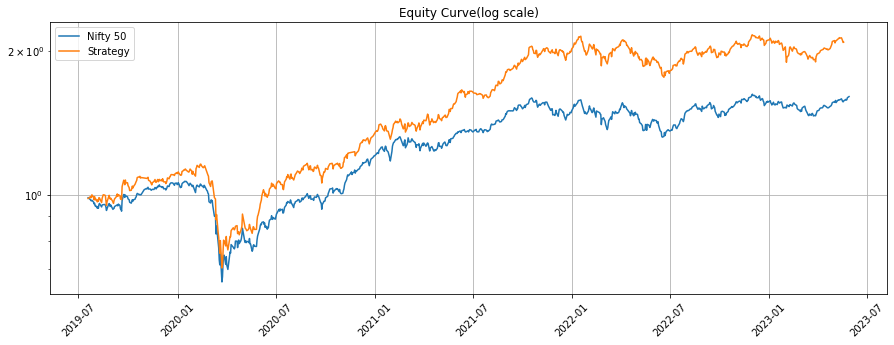

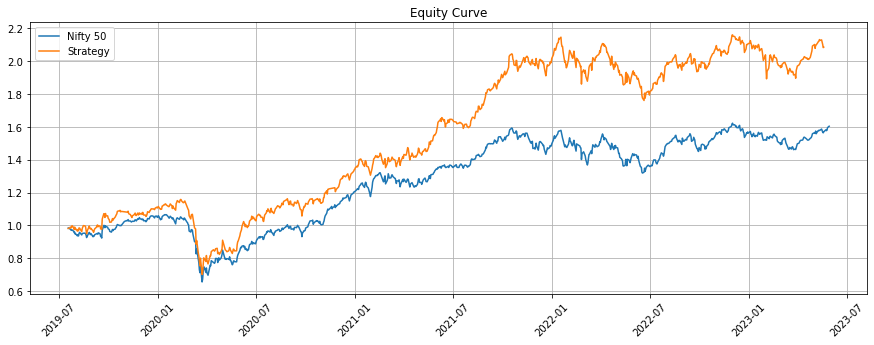

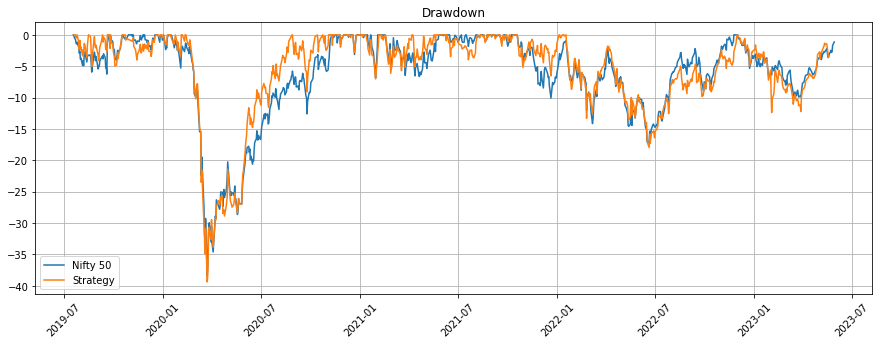

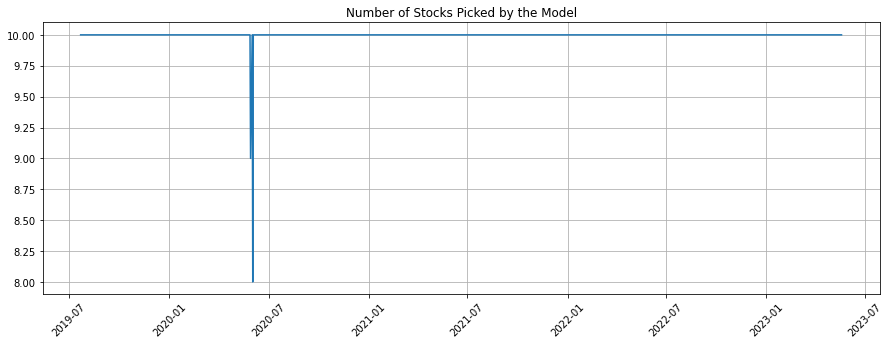

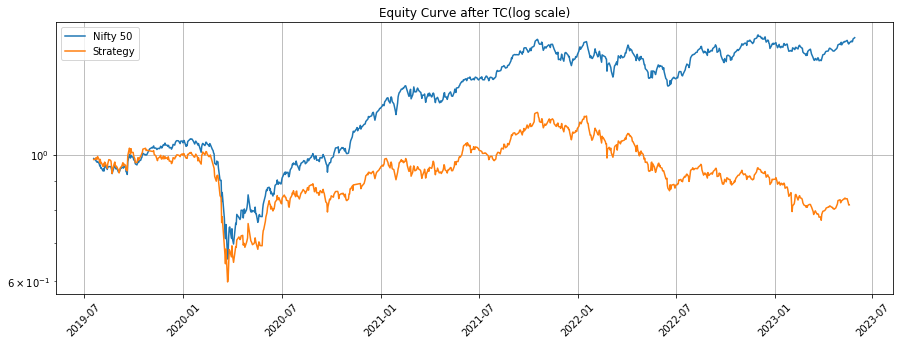

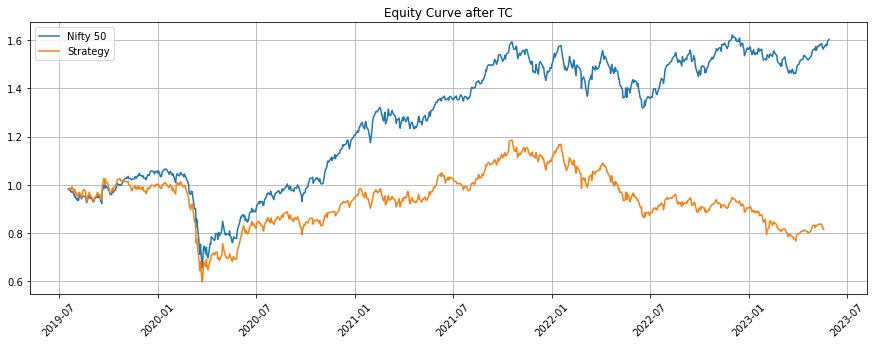

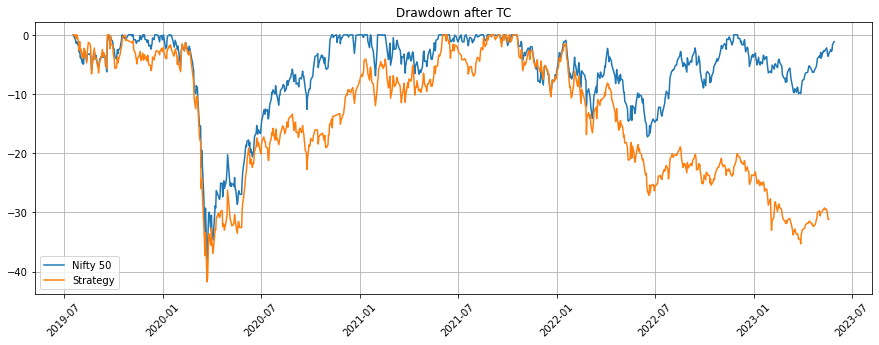

In [74]:
plt.figure(figsize=(15,5))
plt.grid()
plt.yscale('log')
plt.xticks(rotation = 45)
plt.title('Equity Curve(log scale)')
plt.plot(nifty['Strategy_Nav'], label = 'Nifty 50')
plt.plot(strategy_returns['Strategy_Nav'], label = 'Strategy')
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Equity Curve')
plt.plot(nifty['Strategy_Nav'], label = 'Nifty 50')
plt.plot(strategy_returns['Strategy_Nav'], label = 'Strategy')
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Drawdown')
plt.plot(nifty['drawdown'], label = 'Nifty 50')
plt.plot(strategy_returns['drawdown'], label = 'Strategy')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Number of Stocks Picked by the Model')
plt.plot(tt)

plt.figure(figsize=(15,5))
plt.grid()
plt.yscale('log')
plt.xticks(rotation = 45)
plt.title('Equity Curve after TC(log scale)')
plt.plot(nifty['Strategy_Nav'], label = 'Nifty 50')
plt.plot(strategy_returns['Strategy_Nav_after_tc'], label = 'Strategy')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Equity Curve after TC')
plt.plot(nifty['Strategy_Nav'], label = 'Nifty 50')
plt.plot(strategy_returns['Strategy_Nav_after_tc'], label = 'Strategy')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Drawdown after TC')
plt.plot(nifty['drawdown'], label = 'Nifty 50')
plt.plot(strategy_returns['drawdown_adter_tc'], label = 'Strategy')
plt.legend()
plt.show()